In [1]:

#utility imports
import time
import statistics
from team_pace import build_pace_dictionary
from team_pace import build_team_id_dictionary
from scraper import convert_gamelog_to_dataframe

#data sciencey imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#nba_api imports
from nba_api.stats.static import players
from nba_api.stats.static import teams

#CONSTANTS
SEASON = '2019'
TEAM_LIST = teams.get_teams()


In [2]:
#build the pace dictionary - (takes a while)
team_pace_dict = build_pace_dictionary(SEASON)

#build the abbreviation and id dictionary
team_id_dict = build_team_id_dictionary(SEASON)

In [3]:
#find the team abbreviation given the team name
def add_abreviation(team_id):
    return [t["abbreviation"] for t in TEAM_LIST if t["id"] == team_id][0]

#build the season pace dictionary (index = team_id)
pace_df = pd.DataFrame.from_dict(team_pace_dict, "index")

pace_df.rename(columns={0:"pace"}, inplace=True)
pace_df["pace"] = pd.to_numeric(pace_df["pace"])
pace_df["abbv"] = pace_df.apply(lambda row: add_abreviation(row.name), axis=1)

pace_df.sort_values(by=["pace"], ascending=False, inplace=True)

#add the rank column (the method first assigns the higher rank to the first occurence of a duplicate value)
pace_df["rank"] = pace_df["pace"].rank(ascending=False, method="first")

In [4]:
#find some descriptive stats for the pac
pace_mean = pace_df["pace"].mean()
pace_std = pace_df["pace"].std()

print("Mean: ", round(pace_mean,2))
print(" Std: ", round(pace_std,2))


Mean:  99.99
 Std:  2.17


In [5]:
#classify the teams by pace
#label key
# 0 - slower - a team that is more than 1 std below the mean
# 1 - slow - a team that is less than 1 std below the mean
# 2 - fast - a team that is less than 1 std above the mean
# 3 - faster - a team that is more than 1 std above the mean
def label_team_pace(pace, pace_mean, pace_std):
    
    if(pace < pace_mean): 
        if(pace < pace_mean-pace_std): #a slower team
            label = 0
        else: # a slow team
            label = 1
    else:
        if(pace > pace_mean+pace_std): # a faster team
            label = 3
        else: # a fast team
            label = 2
    
    return label

#add the label to the team
pace_df["pace_label"] = pace_df.apply(lambda row: label_team_pace(row.pace, pace_mean, pace_std), axis=1)


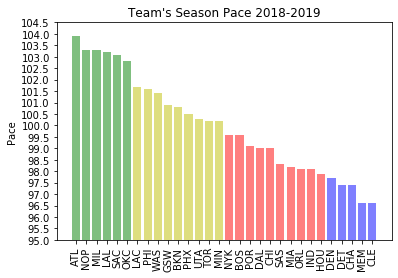

In [6]:
#a nice bar chart

def label_colors(label):
    if(label == 0):
        return 'b'
    elif(label == 1):
        return 'r'
    elif(label == 2):
        return 'y'
    else:
        return 'g'

#settings
y_offset = 95
y_min = 0
y_max = 10
y_step = 0.5

#create the x and y sets and labels
pace_y = pace_df["pace"].apply(lambda x: x - y_offset)
y_labels = np.arange(y_min+y_offset, y_max+y_offset, step=y_step)
x_labels = pace_df["abbv"]
pace_x = np.arange(len(x_labels))
color_labels = pace_df.apply(lambda row: label_colors(row.pace_label), axis=1)

#graph it
plt.bar(pace_x, pace_y, align="center", alpha=0.5, color=color_labels)
plt.xticks(pace_x, x_labels, rotation="vertical")
plt.yticks(np.arange(y_min, y_max, step=y_step), y_labels)
plt.ylabel("Pace")
plt.title("Team's Season Pace 2018-2019")
plt.show()

The bar graph shows a significant range in pace across teams in the NBA.  The Atlanata Hawks have the fastest pace of 103.9 possessions per game.  The Cleveland Cavaliers have the slowest pace with 96.6 possessions per game.  This gives a range of 7.3 possessions per game.  The average pace in the 2018-2019 season was 99.99 possessions/game with a standard deviation of 2.17 possessions/game.  ADD A LEGEND TO THE FIGURE TO EXPLAIN THE CLASSIFICATION AND COLOR OF EACH TEAM.  It's interesting to note the difference at the boundary of faster and fast teams.  The Thunder and Clippers have a difference of 1.1 possessions/game which is much larger than the boundary between the Rockets and Nuggets, which is 0.2 possessions.  There is a large differnce between the slowest two teams and the next highest.  The Grizzlies and Cavaliers both have a pace of 96.6, which is 0.8 possessions/game less than the next highest (Hornets - 97.4).  The higer differnece in a faster team's pace leads me to believe that a faster team will have a stronger effect on their opponents pace during a game.  The difference in pace will be measured by comparing the pace of the game to the teams season average.

In [19]:
#calculate the difference in a team's game pace from their season avg
# parameter - game_pace - the pace for the game
# parameter - team_abv - the team's abbreviation
# returns - the difference in pace
def calc_game_pace_difference(game_pace, team_abv):
    team_id = team_id_dict[team_abv]
    avg_pace = team_pace_dict[team_id]
    
    return float(game_pace) - float(avg_pace)

#calc the difference between the two teams season avg pace
# parameter - team_abv 
# parameter - opp_abv - the opponents abbreviation
# returns the difference in pace
def calc_team_pace_difference(team_abv, opp_abv):
    team_id = team_id_dict[team_abv]
    opp_id = team_id_dict[opp_abv]
    
    return float(team_pace_dict[team_id]) - float(team_pace_dict[opp_id])

In [30]:
#get a dataframe of the teams gamelog and the pace stat
TEAM_ABV = 'ATL'

team_df = convert_gamelog_to_dataframe(TEAM_ABV, SEASON)
team_df = team_df[["game_season","id","date_game","game_location","opp_id", "game_result", "pace"]]


In [34]:
#create the new columns
team_df["game_pace_diff"] = team_df.apply(lambda row: calc_game_pace_difference(row.pace, row.id), axis=1)
team_df["team_pace_diff"] = team_df.apply(lambda row: calc_team_pace_difference(row.id, row.opp_id), axis=1)

team_df.describe()

,game_pace_diff,team_pace_diff
count,82.000000,82.000000
mean,3.847561,-0.148780
std,4.304211,2.002668
min,-3.900000,-3.700000
25%,0.925000,-1.800000
50%,3.300000,0.000000
75%,6.825000,1.500000
max,13.900000,3.000000


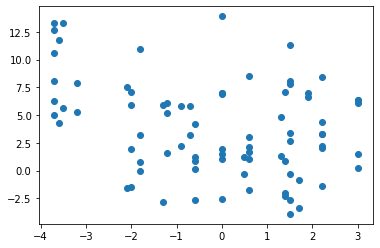

In [33]:
y = team_df["game_pace_diff"]
x = team_df["team_pace_diff"]


plt.scatter(x, y)
plt.show()